In [13]:
%pip install tensorflow==2.15.1

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import time


In [15]:
print(tf.__version__)

2.15.1


In [16]:
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [17]:
import gc
gc.collect()
tf.keras.backend.clear_session()

In [18]:
class ESRGAN:
    """
    Implementation of ESRGAN following the paper:
    'ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks'
    For grayscale medical images.
    """
    def __init__(self, scale_factor=2):
        self.scale_factor = scale_factor
        self.generator = None
        self.discriminator = None
        self.vgg = None
        self.build_models()
        
    def _residual_dense_block(self, x, features=64):
        """Residual Dense Block"""
        concat_features = []
        input_features = x
        
        for i in range(5):
            if concat_features:
                x = layers.Concatenate()(concat_features + [x])
            x = layers.Conv2D(features, (3, 3), padding='same')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            concat_features.append(x)
            
        x = layers.Concatenate()(concat_features)
        x = layers.Conv2D(features, (1, 1), padding='same')(x)
        
        # Local residual learning
        return layers.Add()([input_features, x * 0.2])
    
    def _rrdb_block(self, x, features=64):
        """Residual in Residual Dense Block"""
        input_features = x
        
        for _ in range(3):
            x = self._residual_dense_block(x, features)
            
        # Residual scaling
        return layers.Add()([input_features, x * 0.2])
    
    def build_models(self):
        with tf.device('/GPU:0'):
            # Generator (Modified for Grayscale)
            lr_input = Input(shape=(None, None, 1))  # Grayscale input (single channel)
            
            # First conv
            x = layers.Conv2D(64, (3, 3), padding='same')(lr_input)
            initial_feature = x
            
            # RRDB blocks (23 blocks as in paper)
            for _ in range(23):
                x = self._rrdb_block(x)
                
            # Global feature fusion
            x = layers.Conv2D(64, (3, 3), padding='same')(x)
            trunk = layers.Add()([initial_feature, x])
            

           # Dynamic upsampling based on scale_factor
            upsample_blocks = int(tf.math.log(float(self.scale_factor)) / tf.math.log(2.0))  # Calculate # of 2x upsampling blocks
            
            for _ in range(upsample_blocks):
                x = layers.Conv2D(256, (3, 3), padding='same')(trunk)
                x = tf.nn.depth_to_space(x, 2)  # Pixel shuffle
                x = layers.LeakyReLU(0.2)(x)
                trunk = x



            
            # Final conv
            sr_output = layers.Conv2D(1, (3, 3), padding='same', activation='tanh')(trunk)  # Single channel output
            
            self.generator = Model(lr_input, sr_output, name='generator')
            
            # Discriminator (Modified for Grayscale)
            def d_block(x, filters, strides=1, bn=True):
                x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
                if bn:
                    x = layers.BatchNormalization()(x)
                return layers.LeakyReLU(alpha=0.2)(x)
            
            d_input = Input(shape=(None, None, 1))  # Grayscale input
            
            # Series of Conv + LeakyReLU + BN
            features = [64, 64, 128, 128, 256, 256, 512, 512]
            x = d_input
            
            for idx, f in enumerate(features):
                x = d_block(x, f, strides=2 if idx % 2 == 1 else 1)
            
            x = layers.GlobalAveragePooling2D()(x)
            x = layers.Dense(1024)(x)
            x = layers.LeakyReLU(0.2)(x)
            x = layers.Dense(1, activation='sigmoid')(x)
            
            self.discriminator = Model(d_input, x, name='discriminator')
            
            # VGG feature extractor for perceptual loss
            vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))  # VGG expects 3 channels, but we'll use grayscale
            self.vgg = Model(inputs=vgg.input,
                            outputs=vgg.get_layer('block5_conv4').output,
                            name='vgg')
            self.vgg.trainable = False
        
    def compile(self, 
                gen_lr=1e-4, 
                disc_lr=1e-4,
                content_weight=1.0,
                perceptual_weight=1.0,
                adversarial_weight=0.1):
        
        self.gen_optimizer = tf.keras.optimizers.Adam(gen_lr, beta_1=0.9, beta_2=0.99)
        self.disc_optimizer = tf.keras.optimizers.Adam(disc_lr, beta_1=0.9, beta_2=0.99)
        
        self.content_weight = content_weight
        self.perceptual_weight = perceptual_weight
        self.adversarial_weight = adversarial_weight
        
    @tf.function
    def train_step(self, lr_images, hr_images):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake images
            sr_images = self.generator(lr_images, training=True)
            
            # Discriminator outputs
            real_output = self.discriminator(hr_images, training=True)
            fake_output = self.discriminator(sr_images, training=True)
            
            # Content loss (L1 loss as per paper)
            content_loss = tf.reduce_mean(tf.abs(hr_images - sr_images))
            
            # Extract features using VGG (for perceptual loss)
            hr_images_rgb = tf.repeat(hr_images, repeats=3, axis=-1)
            sr_images_rgb = tf.repeat(sr_images, repeats=3, axis=-1)

            hr_features = self.vgg(hr_images_rgb)
            sr_features = self.vgg(sr_images_rgb)

            perceptual_loss = tf.reduce_mean(tf.abs(hr_features - sr_features))
            
            # Relativistic average GAN loss
            real_logits = real_output - tf.reduce_mean(fake_output)
            fake_logits = fake_output - tf.reduce_mean(real_output)
            
            disc_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.ones_like(real_logits), logits=real_logits
                ) +
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.zeros_like(fake_logits), logits=fake_logits
                )
            )
            
            gen_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.ones_like(fake_logits), logits=fake_logits
                ) +
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.zeros_like(real_logits), logits=real_logits
                )
            )
            
            # Total generator loss
            total_gen_loss = (
                self.content_weight * content_loss +
                self.perceptual_weight * perceptual_loss +
                self.adversarial_weight * gen_loss
            )
            
        # Compute gradients
        gen_gradients = gen_tape.gradient(
            total_gen_loss, self.generator.trainable_variables
        )
        disc_gradients = disc_tape.gradient(
            disc_loss, self.discriminator.trainable_variables
        )
        
        # Apply gradients
        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.generator.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.discriminator.trainable_variables)
        )
        
        return {
            'content_loss': content_loss,
            'perceptual_loss': perceptual_loss,
            'gen_loss': gen_loss,
            'disc_loss': disc_loss,
            'total_gen_loss' : total_gen_loss
        }

In [19]:
class DataLoader:
    def __init__(self, image_dir, batch_size=16, hr_size=1024, scale_factor=4):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.hr_size = hr_size
        self.lr_size = hr_size // scale_factor
        self.scale_factor = scale_factor
        
        self.dataset = self._create_dataset()
    
    def _load_and_process(self, path):
        # Load image
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)  # Read as grayscale
        img = tf.cast(img, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
        
        # Random crop
        # img = tf.image.random_crop(img, [self.hr_size, self.hr_size, 1])
        img = tf.image.resize(img, [self.hr_size, self.hr_size],
                               method='bicubic')
        # Create low-res version
        lr_img = tf.image.resize(img, [self.lr_size, self.lr_size],
                               method='bicubic')
        
        return lr_img, img
    
    def _create_dataset(self):
        # Get image paths
        image_paths = tf.data.Dataset.list_files(str(self.image_dir + '/*'))
        
        # Create dataset
        dataset = (image_paths
                  .map(self._load_and_process, num_parallel_calls=tf.data.AUTOTUNE)
                  .batch(self.batch_size)
                  .prefetch(tf.data.AUTOTUNE))
        
        return dataset
    
# Initialize model
model = ESRGAN(scale_factor=4)

Compile with custom loss weights if needed

In [20]:
model.compile(
    gen_lr=1e-4, 
    disc_lr=1e-4,
    content_weight=1.0, 
    perceptual_weight=1.0,
    adversarial_weight=1.0
)

Load data

In [21]:
data_loader = DataLoader(image_dir='/kaggle/input/data/images_007/images', batch_size=4, hr_size=128, scale_factor=4)

Training loop

In [22]:
tf.debugging.set_log_device_placement(True)

In [23]:
# Create a history dictionary to store losses over time
history = {
    'content_loss': [],
    'perceptual_loss': [],
    'gen_loss': [],
    'disc_loss': [],
    'total_gen_loss': []
}

epochs = 5

# Training loop
for epoch in range(epochs):
    start_time = time.time()
    print(f"\nEpoch {epoch + 1}/{epochs}")

    for batch_idx, (lr_images, hr_images) in enumerate(data_loader.dataset):
        # Perform training step
        losses = model.train_step(lr_images, hr_images)

        # Append the current batch losses to the history dictionary
        history['content_loss'].append(losses['content_loss'].numpy())
        history['perceptual_loss'].append(losses['perceptual_loss'].numpy())
        history['gen_loss'].append(losses['gen_loss'].numpy())
        history['disc_loss'].append(losses['disc_loss'].numpy())
        history['total_gen_loss'].append(losses['total_gen_loss'].numpy())

        # Print the losses every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Batch {batch_idx + 1} - "
                  f"Content Loss: {losses['content_loss']:.4f}, "
                  f"Perceptual Loss: {losses['perceptual_loss']:.4f}, "
                  f"Gen Loss: {losses['gen_loss']:.4f}, "
                  f"Disc Loss: {losses['disc_loss']:.4f}, "
                  f"Total Generator Loss: {losses['total_gen_loss']:.4f}")
                    

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")


Epoch 1/5
Batch 100 - Content Loss: 0.2627, Perceptual Loss: 0.0922, Gen Loss: 2.1987, Disc Loss: 0.8183, Total Generator Loss: 2.5537
Batch 200 - Content Loss: 0.1616, Perceptual Loss: 0.0810, Gen Loss: 1.3282, Disc Loss: 1.4517, Total Generator Loss: 1.5708
Batch 300 - Content Loss: 0.1198, Perceptual Loss: 0.0851, Gen Loss: 1.8625, Disc Loss: 1.0152, Total Generator Loss: 2.0674
Batch 400 - Content Loss: 0.1438, Perceptual Loss: 0.0809, Gen Loss: 1.4542, Disc Loss: 1.3275, Total Generator Loss: 1.6789
Batch 500 - Content Loss: 0.1194, Perceptual Loss: 0.0851, Gen Loss: 1.3685, Disc Loss: 1.4053, Total Generator Loss: 1.5730
Batch 600 - Content Loss: 0.1098, Perceptual Loss: 0.0851, Gen Loss: 1.6404, Disc Loss: 1.1770, Total Generator Loss: 1.8353
Batch 700 - Content Loss: 0.1174, Perceptual Loss: 0.0809, Gen Loss: 1.6386, Disc Loss: 1.2028, Total Generator Loss: 1.8370
Batch 800 - Content Loss: 0.1603, Perceptual Loss: 0.0823, Gen Loss: 1.5972, Disc Loss: 1.2740, Total Generator Lo

In [26]:
# Convert configuration to serializable format
def convert_to_serializable(obj):
    if isinstance(obj, (tf.Tensor, tf.Variable)):
        return obj.numpy().tolist()
    if isinstance(obj, (np.ndarray, tf.DType, np.generic)):
        return obj.tolist()
    if isinstance(obj, (float, int, str, list, dict)):
        return obj
    return str(obj)  # Fallback for any unsupported types

# Save training configurations (convert to JSON serializable format)
config = {
    'scale_factor': model.scale_factor,
    'gen_optimizer_config': {
        k: convert_to_serializable(v) for k, v in model.gen_optimizer.get_config().items()
    },
    'disc_optimizer_config': {
        k: convert_to_serializable(v) for k, v in model.disc_optimizer.get_config().items()
    },
    'content_weight': float(model.content_weight),
    'perceptual_weight': float(model.perceptual_weight),
    'adversarial_weight': float(model.adversarial_weight)
}

import json
with open('esrgan_models/training_config.json', 'w') as f:
    json.dump(config, f)


Visualize the loss values

In [27]:
import matplotlib.pyplot as plt

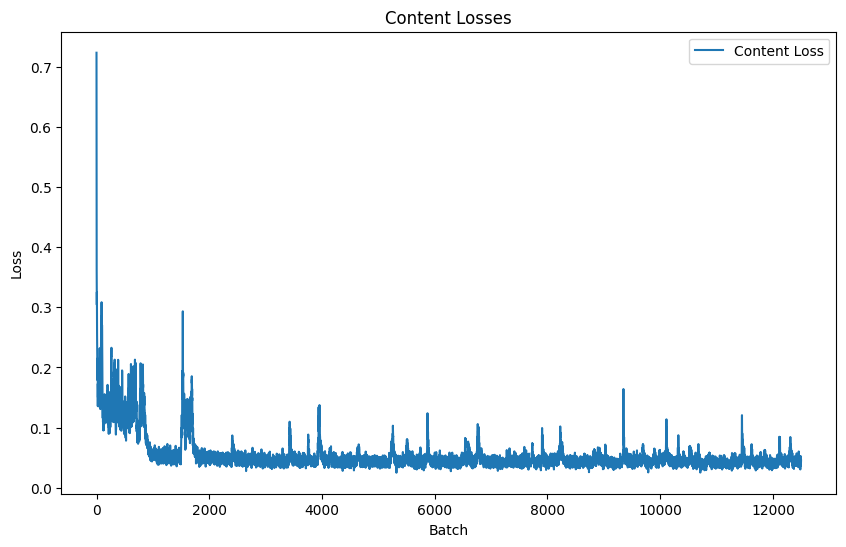

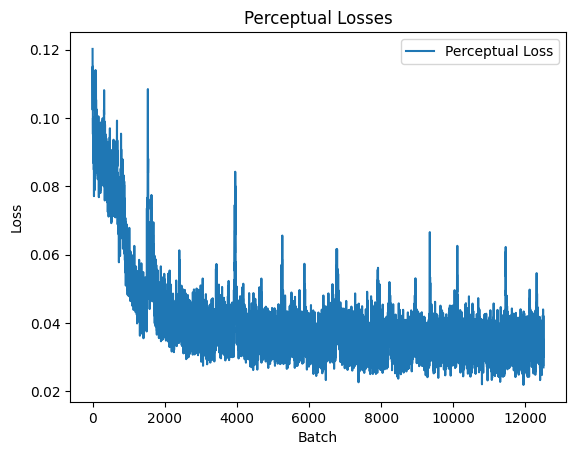

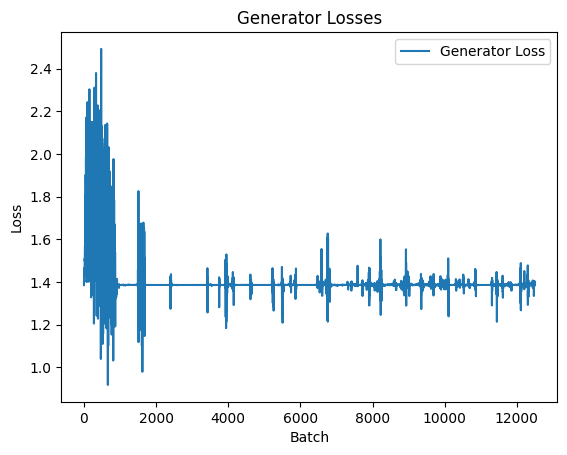

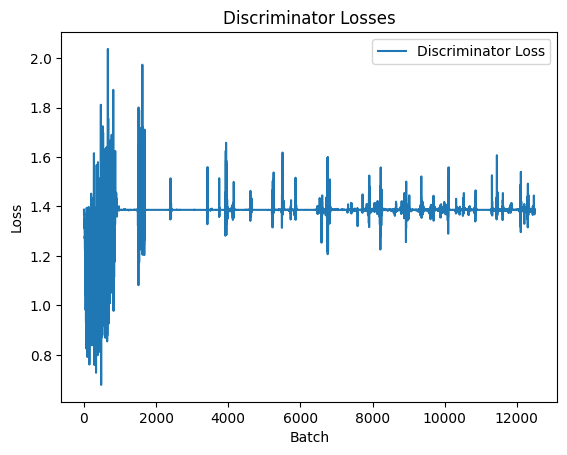

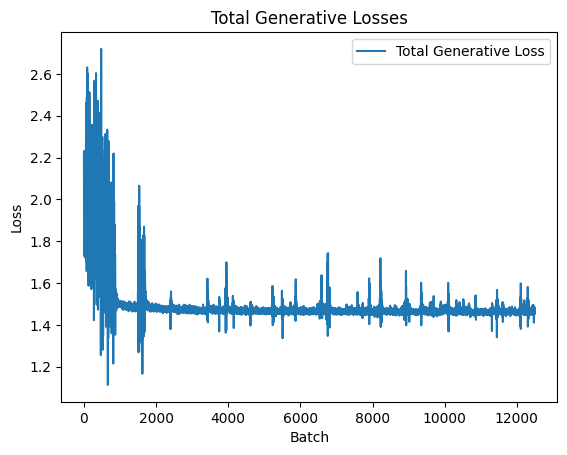

In [28]:
# After training, plot the accumulated loss values
plt.figure(figsize=(10, 6))
plt.plot(history['content_loss'], label='Content Loss')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Content Losses')
plt.show()
plt.plot(history['perceptual_loss'], label='Perceptual Loss')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Perceptual Losses')
plt.show()
plt.plot(history['gen_loss'], label='Generator Loss')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Generator Losses')
plt.show()
plt.legend()
plt.plot(history['disc_loss'], label='Discriminator Loss')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Discriminator Losses')
plt.show()
plt.plot(history['total_gen_loss'], label='Total Generative Loss')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Total Generative Losses')
plt.show()

Visualize the generated images and original high-res images and low-res images

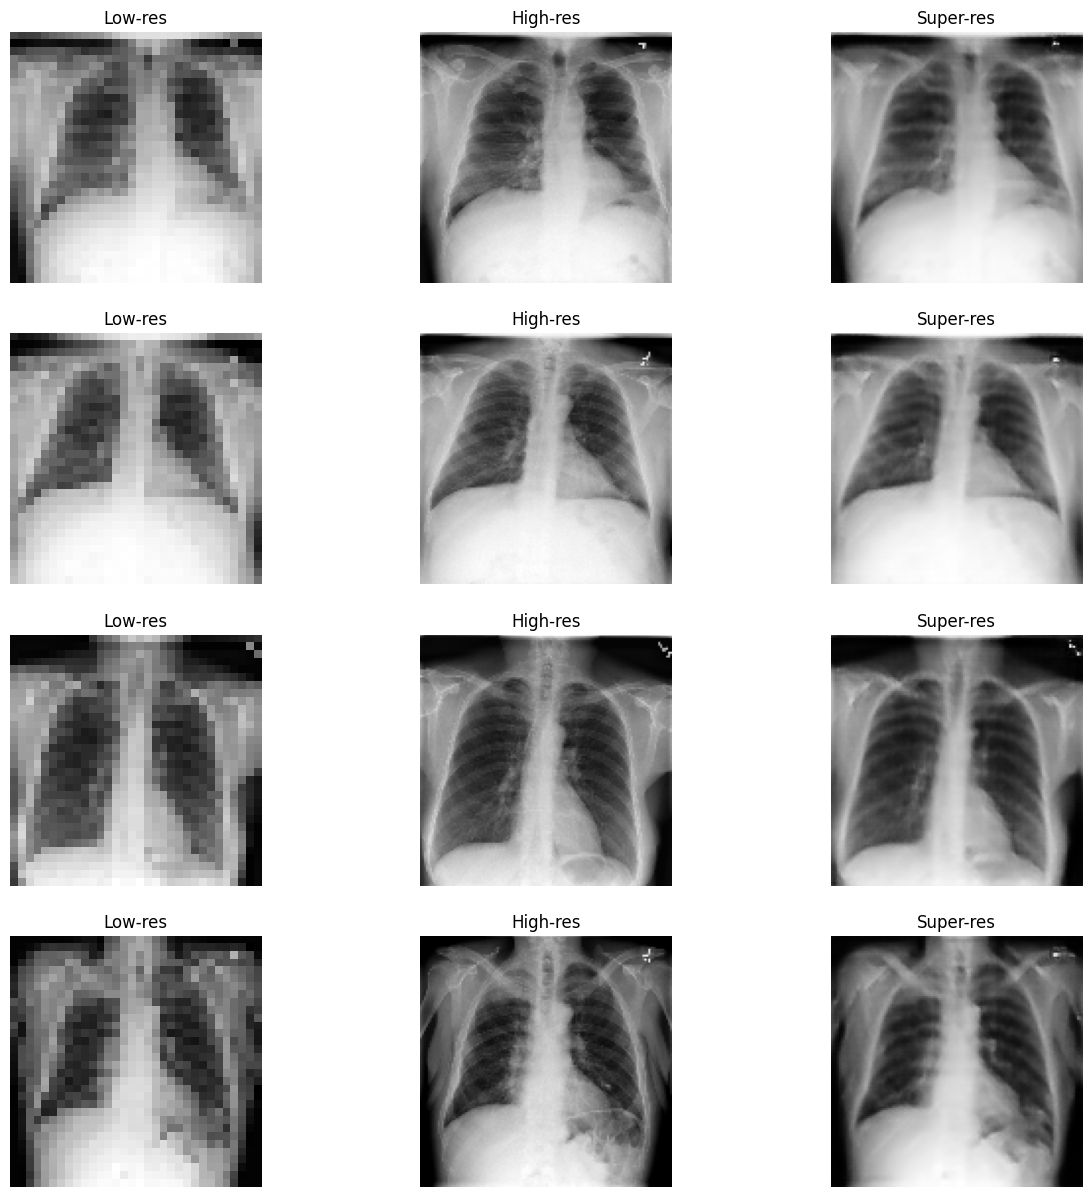

In [29]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(tf.squeeze(lr_images[i]), cmap='gray')
    plt.title('Low-res')
    plt.axis('off')
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tf.squeeze(hr_images[i]), cmap='gray')
    plt.title('High-res')
    plt.axis('off')
    
    sr_images = model.generator(lr_images, training=False)
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tf.squeeze(sr_images[i]), cmap='gray')
    plt.title('Super-res')
    plt.axis('off')

In [30]:
plt.show()

## 1. Quantitative Metrics:

## a) Peak Signal-to-Noise Ratio (PSNR) 
## b) Structural Similarity Index (SSIM) 
## c) Mean Absolute Error (MAE)

In [31]:
def psnr(img1, img2):
    return tf.image.psnr(img1, img2, max_val=1.0)

def ssim(img1, img2):
    return tf.image.ssim(img1, img2, max_val=1.0)

def mae(img1, img2):
    return tf.reduce_mean(tf.abs(img1 - img2))


In [32]:
test_loader = DataLoader(image_dir='/kaggle/input/data/images_008/images', batch_size=4, hr_size=128, scale_factor=4)

Testing model...

Batch 0/2500 - PSNR: 21.0120, SSIM: 0.7669, MAE: 0.0473
Batch 100/2500 - PSNR: 22.6959, SSIM: 0.7989, MAE: 0.0363
Batch 200/2500 - PSNR: 21.0037, SSIM: 0.7651, MAE: 0.0447
Batch 300/2500 - PSNR: 19.9814, SSIM: 0.7311, MAE: 0.0542
Batch 400/2500 - PSNR: 23.1631, SSIM: 0.7948, MAE: 0.0398
Batch 500/2500 - PSNR: 20.8397, SSIM: 0.7871, MAE: 0.0440
Batch 600/2500 - PSNR: 20.4075, SSIM: 0.7708, MAE: 0.0468
Batch 700/2500 - PSNR: 19.7544, SSIM: 0.7911, MAE: 0.0431
Batch 800/2500 - PSNR: 20.3987, SSIM: 0.8038, MAE: 0.0460
Batch 900/2500 - PSNR: 22.1317, SSIM: 0.7951, MAE: 0.0381
Batch 1000/2500 - PSNR: 21.3236, SSIM: 0.7967, MAE: 0.0454
Batch 1100/2500 - PSNR: 19.9884, SSIM: 0.7952, MAE: 0.0451
Batch 1200/2500 - PSNR: 22.7985, SSIM: 0.8137, MAE: 0.0354
Batch 1300/2500 - PSNR: 22.0450, SSIM: 0.7789, MAE: 0.0394
Batch 1400/2500 - PSNR: 23.5246, SSIM: 0.8102, MAE: 0.0347
Batch 1500/2500 - PSNR: 23.8458, SSIM: 0.7474, MAE: 0.0355
Batch 1600/2500 - PSNR: 23.7685, SSIM: 0.7753, MAE

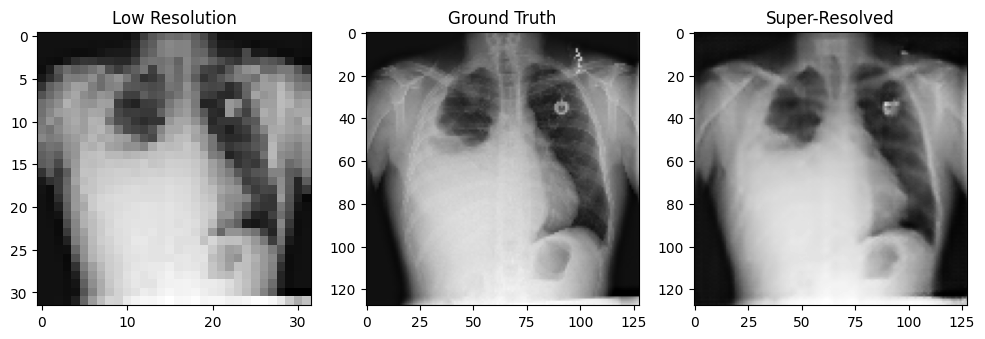

In [35]:
# Assuming you have a test dataset and the model is ready
def test_model(model, test_loader):
    psnr_values = []
    ssim_values = []
    mae_values = []
    
    # Get the total number of batches for progress tracking
    total_batches = len(test_loader.dataset)
    
    # Initialize a progress bar or use simple print for feedback
    print("Testing model...\n")
    
    for batch_idx, (lr_images, hr_images) in enumerate(test_loader.dataset):
        sr_images = model.generator(lr_images, training=False)
    
        # Reduce the arrays to scalars
        psnr_value = np.mean(psnr(hr_images, sr_images).numpy())
        ssim_value = np.mean(ssim(hr_images, sr_images).numpy())
        mae_value = np.mean(mae(hr_images, sr_images).numpy())
    
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        mae_values.append(mae_value)
    
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{total_batches} - PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}, MAE: {mae_value:.4f}")

    # Compute average values
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    avg_mae = np.mean(mae_values)

    print(f"\nTesting completed!")
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")

    # Example visualization of results
    idx = 0  # You can change this to visualize different examples
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_images[idx], cmap='gray')
    plt.title("Low Resolution")
    plt.subplot(1, 3, 2)
    plt.imshow(hr_images[idx], cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(sr_images[idx], cmap='gray')
    plt.title("Super-Resolved")
    plt.show()

# Run the testing function
test_model(model, test_loader)
